Import standard libraries

In [1]:
# Import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

from xgboost import XGBClassifier
import shap

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

import dataset


In [2]:
df = pd.read_csv("mtn_customer_churn.csv")

In [3]:
df.head(5)

,Customer ID,Full Name,Date of Purchase,Age,State,MTN Device,Gender,Satisfaction Rate,Customer Review,Customer Tenure in months,Subscription Plan,Unit Price,Number of Times Purchased,Total Revenue,Data Usage,Customer Churn Status,Reasons for Churn
0,CUST0001,Ngozi Berry,Jan-25,27,Kwara,4G Router,Male,2,Fair,2,165GB Monthly Plan,35000,19,665000,44.48,Yes,Relocation
1,CUST0002,Zainab Baker,Mar-25,16,Abuja (FCT),Mobile SIM Card,Female,2,Fair,22,12.5GB Monthly Plan,5500,12,66000,19.79,Yes,Better Offers from Competitors
2,CUST0003,Saidu Evans,Mar-25,21,Sokoto,5G Broadband Router,Male,1,Poor,60,150GB FUP Monthly Unlimited,20000,8,160000,9.64,No,NaN
3,CUST0003,Saidu Evans,Mar-25,21,Sokoto,Mobile SIM Card,Male,1,Poor,60,1GB+1.5mins Daily Plan,500,8,4000,197.05,No,NaN
4,CUST0003,Saidu Evans,Mar-25,21,Sokoto,Broadband MiFi,Male,1,Poor,60,30GB Monthly Broadband Plan,9000,15,135000,76.34,No,NaN


checking for duplicates

In [4]:
# Count number of unique customers vs total records
unique_customers = df['Customer ID'].nunique()
total_records = len(df)

print(f"Total Records: {total_records}")
print(f"Unique Customers: {unique_customers}")

Total Records: 974
Unique Customers: 496


clean and aggregate data

In [5]:
# Convert Date of Purchase to datetime
df['Date of Purchase'] = pd.to_datetime(df['Date of Purchase'], format='%b-%y')

# Create a feature for Recency
latest_date = df['Date of Purchase'].max()
df['Recency'] = (latest_date - df['Date of Purchase']).dt.days

# Define aggregation rules
agg_dict = {
    'Age': 'mean',
    'Satisfaction Rate': 'mean',
    'Customer Tenure in months': 'max',
    'Total Revenue': 'sum',
    'Data Usage': 'sum',
    'Number of Times Purchased': 'sum',
    'Recency': 'min',
    'MTN Device': lambda x: ', '.join(x.unique()),
    'Gender': 'first',
    'State': 'first',
    'Customer Churn Status': 'first',
    'Reasons for Churn': 'first'
}

# Group by Customer ID
df_agg = df.groupby('Customer ID').agg(agg_dict).reset_index()

Feature Engineering

In [6]:
# Number of devices used per customer
df_agg['Number of Devices'] = df_agg['MTN Device'].apply(lambda x: len(str(x).split(',')))

# Average monthly revenue
df_agg['Avg Monthly Revenue'] = df_agg['Total Revenue'] / df_agg['Customer Tenure in months']

# Fill missing values
df_agg.fillna({
    'Avg Monthly Revenue': 0,
    'Satisfaction Rate': 3  # Neutral
}, inplace=True)

 Encode Target Variable

In [7]:
df_agg['Churn'] = df_agg['Customer Churn Status'].map({'Yes': 1, 'No': 0})

Exploratory Data Analysis (EDA)

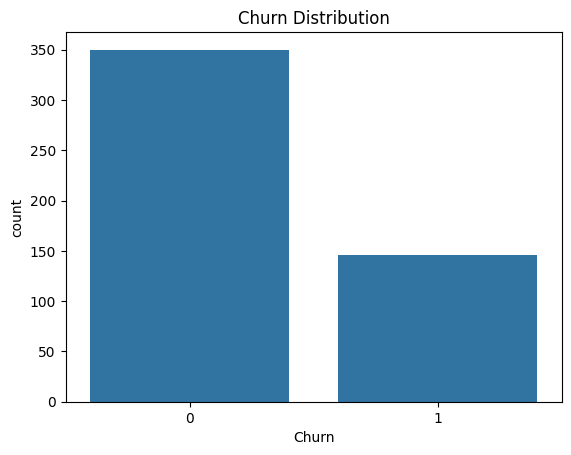

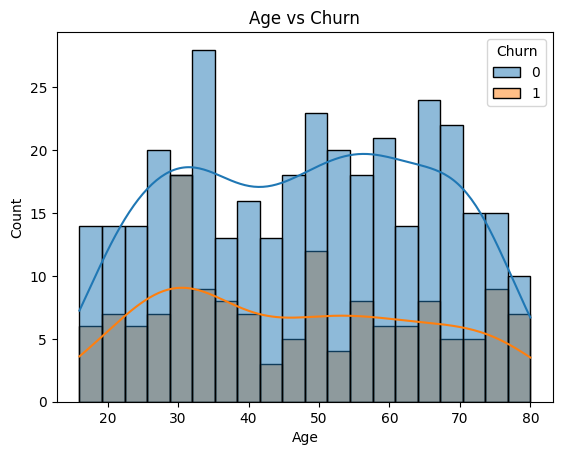

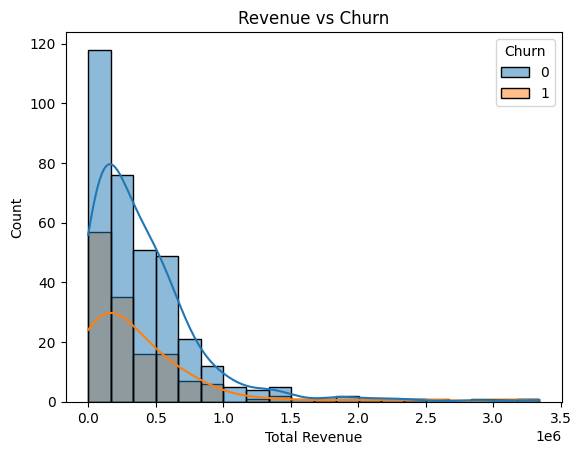

In [8]:
# Distribution of Churn
sns.countplot(data=df_agg, x='Churn')
plt.title('Churn Distribution')
plt.show()

# Age vs Churn
sns.histplot(data=df_agg, x='Age', hue='Churn', bins=20, kde=True)
plt.title('Age vs Churn')
plt.show()

# Revenue vs Churn
sns.histplot(data=df_agg, x='Total Revenue', hue='Churn', bins=20, kde=True)
plt.title('Revenue vs Churn')
plt.show()

Prepare Features for Modeling

In [10]:
# Select features and target
X = df_agg.drop(columns=['Churn', 'Customer ID', 'Customer Churn Status', 'MTN Device', 'Reasons for Churn'])
y = df_agg['Churn']

# Identify categorical and numerical columns
categorical_cols = ['Gender', 'State']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# Preprocessor pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

X_preprocessed = preprocessor.fit_transform(X)

Train/Test Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, stratify=y, random_state=42)

Train Model (Random Forest)

In [12]:
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

Evaluate Model

              precision    recall  f1-score   support

           0       0.71      0.96      0.81        71
           1       0.25      0.03      0.06        29

    accuracy                           0.69       100
   macro avg       0.48      0.50      0.44       100
weighted avg       0.58      0.69      0.60       100

ROC AUC Score: 0.4193783389995144


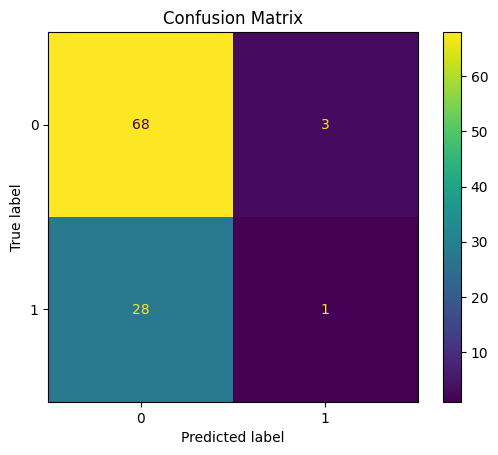

In [13]:
# Classification report
print(classification_report(y_test, y_pred))

# ROC AUC Score
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

Clean and Analyze Text

In [16]:
# Extract 'Reasons for Churn' data
reasons_df = df_agg[['Customer ID', 'Reasons for Churn']].copy()
reasons_df = reasons_df[reasons_df['Reasons for Churn'].notna()]

# Clean text
def clean_text(text):
    if pd.isna(text):
        return ''
    text = text.lower().strip()
    text = ''.join([c for c in text if c.isalnum() or c in [' ', '-']])
    return text

reasons_df['Cleaned Reason'] = reasons_df['Reasons for Churn'].apply(clean_text)

Word Cloud of Churn Reasons

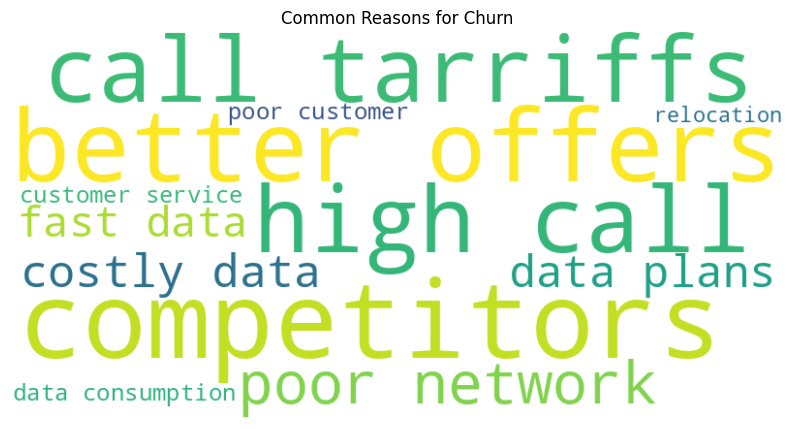

In [17]:
# Generate word cloud
text = ' '.join(reasons_df['Cleaned Reason'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Common Reasons for Churn')
plt.show()

Top Keywords in Churn Reasons

<ipython-input-18-2127629990>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=common_words_df, x='Count', y='Word', palette='viridis')


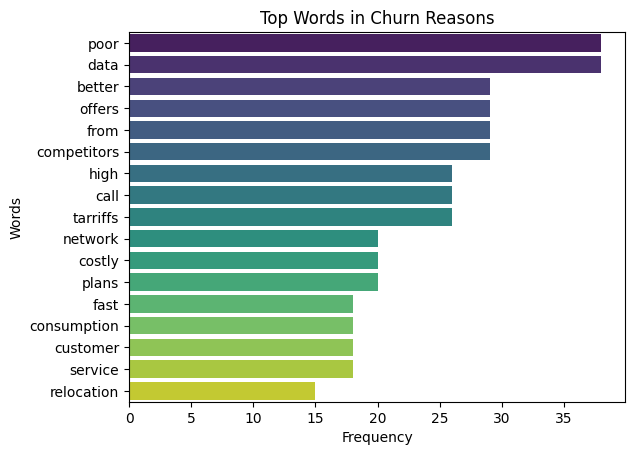

In [18]:
from collections import Counter
import re

# Extract words
words = re.findall(r'\w+', text)
common_words = Counter(words).most_common(20)

# Display top words
common_words_df = pd.DataFrame(common_words, columns=['Word', 'Count'])
sns.barplot(data=common_words_df, x='Count', y='Word', palette='viridis')
plt.title('Top Words in Churn Reasons')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

Topic Modeling with TF-IDF + KMeans

In [19]:
# Vectorize using TF-IDF
vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
X_reasons = vectorizer.fit_transform(reasons_df['Cleaned Reason'])

# Clustering
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_reasons)

reasons_df['Cluster'] = clusters

# Show sample reasons per cluster
for cluster in range(5):
    print(f"\n--- Cluster {cluster} ---")
    sample = reasons_df[reasons_df['Cluster'] == cluster]['Reasons for Churn'].sample(3)
    for reason in sample:
        print("- ", reason)


--- Cluster 0 ---
-  Relocation
-  Poor Customer Service
-  Relocation

--- Cluster 1 ---
-  Better Offers from Competitors
-  Better Offers from Competitors
-  Better Offers from Competitors

--- Cluster 2 ---
-  Poor Network
-  Poor Network
-  Poor Network

--- Cluster 3 ---
-  High Call Tarriffs
-  High Call Tarriffs
-  High Call Tarriffs

--- Cluster 4 ---
-  Costly Data Plans
-  Costly Data Plans
-  Fast Data Consumption


Save Final Dataset for Future Use

In [20]:
# Save aggregated dataset
df_agg.to_csv("mtn_customer_churn_aggregated.csv", index=False)

# Save cleaned churn reasons dataset
reasons_df.to_csv("mtn_churn_reasons_cleaned.csv", index=False)

print("Datasets saved!")

Datasets saved!
